# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [7]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [10]:
 # define your regions here
presel = {
        "mu": {
            "met": "met_pt<20",
#             "met": "met_pt>10",
#             "fj_mass": "fj_mass>10",
            "miso": " (loose_lep1_pt<55) | ( (loose_lep1_pt>55) & (loose_lep1_miso<0.8) ) "            
        },
        "ele": {
            "met": "met_pt<20",
#             "met": "met_pt>10",
#             "fj_mass": "fj_mass>10",
        },
}


channels = ["ele", "mu"]
samples = [
    "QCD",
    "Data",
    "DYJets",
    "WJetsLNu",
]

years = ["2016", "2016APV", "2017", "2018"]
# years = ["2017"]

samples_dir = {
    "ele": {
        "2018": "../eos/fake_rate_extraction/May31_fakes_2018",
        "2017": "../eos/fake_rate_extraction/May31_fakes_2017",
        "2016": "../eos/fake_rate_extraction/May31_fakes_2016",
        "2016APV": "../eos/fake_rate_extraction/May31_fakes_2016APV",
    },
    
    "mu": {
        "2018": "../eos/fake_rate_extraction/Oct9_fakes_mu_2018",
        "2017": "../eos/fake_rate_extraction/Oct9_fakes_mu_2017",
        "2016": "../eos/fake_rate_extraction/Oct9_fakes_mu_2016",
        "2016APV": "../eos/fake_rate_extraction/Oct9_fakes_mu_2016APV",
    },
}

In [11]:
from make_stacked_hists import make_events_dict

channels = [
    "ele",
    "mu",
]

out = {}
for ch in channels:
    out[ch] = make_events_dict(years, [ch], samples_dir[ch], samples, presel)

# wrap
events_dict = {}
for year in years:
    events_dict[year] = {}
    for ch in channels:
        events_dict[year][ch] = out[ch][year][ch]

INFO:root:Processing 2016, ele channel
INFO:root:Processing 2016APV, ele channel
INFO:root:Processing 2017, ele channel
INFO:root:Processing 2018, ele channel
INFO:root:Processing 2016, mu channel
INFO:root:Processing 2016APV, mu channel
INFO:root:Processing 2017, mu channel
INFO:root:Processing 2018, mu channel


# Stacked hists

In [12]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)

In [13]:
for key in events_dict["2017"]["ele"]["Data"].keys():
    print(key)

N_tight_lep
N_loose_lep
tight_lep1_pt
tight_lep1_eta
tight_lep2_pt
tight_lep2_eta
mll_tight
loose_lep1_pt
loose_lep1_eta
loose_lep2_pt
loose_lep2_eta
mll_loose
met_pt
NumFatjets
lep_fj_dr
fj_pt
fj_eta
fj_phi
mT_tight1
mT_loose1
xsecweight
nominal


In [16]:
vars_to_plot = [
#     "N_tight_lep",
#     "N_loose_lep",
    "tight_lep1_pt",
#     "tight_lep1_eta",
#     "tight_lep2_pt",
#     "tight_lep2_eta",
#     "mll_tight",
    "loose_lep1_pt",
#     "loose_lep1_eta",
#     "loose_lep2_pt",
#     "loose_lep2_eta",
#     "mll_loose",
#     "met_pt",
#     "mT_loose1",
#     "mT_tight1",
]

samples_to_plot = [
    "QCD",
    "Data",
    "DYJets",
#     "WJetsLNu",    
]

In [17]:
import utils

axis_dict = {}
axis_dict["ele"] = {
    "loose_lep1_pt": hist2.axis.Regular(25, 38, 400, name="var", label=r"Loose electron $p_T$ [GeV]", overflow=True),    
    "loose_lep1_eta": hist2.axis.Regular(20, 0, 2.4, name="var", label=r"Loose electron |$\eta$|", overflow=True),    

    "tight_lep1_pt": hist2.axis.Regular(25, 38, 200, name="var", label=r"Tight electron $p_T$ [GeV]", overflow=True), 
    "tight_lep1_eta": hist2.axis.Regular(20, 0, 2.4, name="var", label=r"Tight electron |$\eta$|", overflow=True),

    "met_pt": hist2.axis.Regular(40, 0, 20, name="var", label=r"MET [GeV]", overflow=True),

    "loose_lep1_eta_endcaps": hist2.axis.Regular(15, 1.57, 2.4, name="var", label=r"Loose electron |$\eta$|", overflow=True),
    "tight_lep1_eta_endcaps": hist2.axis.Regular(15, 1.57, 2.4, name="var", label=r"Tight electron |$\eta$|", overflow=True),

    "loose_lep1_eta_barrel": hist2.axis.Regular(20, 0, 1.57, name="var", label=r"Loose electron |$\eta$|", overflow=True),
    "tight_lep1_eta_barrel": hist2.axis.Regular(20, 0, 1.57, name="var", label=r"Tight electron |$\eta$|", overflow=True),
}

axis_dict["mu"] = {
    "loose_lep1_pt": hist2.axis.Regular(15, 30, 300, name="var", label=r"Loose muon $p_T$ [GeV]", overflow=True),    
    "loose_lep1_eta": hist2.axis.Regular(20, 0, 2.4, name="var", label=r"Loose muon |$\eta$|", overflow=True),    

    "tight_lep1_pt": hist2.axis.Regular(25, 30, 200, name="var", label=r"Tight muon $p_T$ [GeV]", overflow=True), 
    "tight_lep1_eta": hist2.axis.Regular(20, 0, 2.4, name="var", label=r"Tight muon |$\eta$|", overflow=True),

    "met_pt": hist2.axis.Regular(40, 0, 20, name="var", label=r"MET [GeV]", overflow=True),
    
    "loose_lep1_eta_endcaps": hist2.axis.Regular(15, 1.479, 2.4, name="var", label=r"Loose muon |$\eta$|", overflow=True),
    "tight_lep1_eta_endcaps": hist2.axis.Regular(15, 1.479, 2.4, name="var", label=r"Tight muon |$\eta$|", overflow=True),

    "loose_lep1_eta_barrel": hist2.axis.Regular(20, 0, 1.479, name="var", label=r"Loose muon |$\eta$|", overflow=True),
    "tight_lep1_eta_barrel": hist2.axis.Regular(20, 0, 1.479, name="var", label=r"Tight muon |$\eta$|", overflow=True),        
}

years = [
    "2016", 
    "2016APV", 
    "2017",
    "2018",
]

channels = [
    "ele",
    "mu",
]

# cut = "endcaps"
cut = "barrel"
# cut = ""

# fill histograms
hists = {}

for ch in channels:
    for var in vars_to_plot:

        if ("barrel" in cut) and ("eta" in var):
            ax = axis_dict[ch][var + "_barrel"]
        elif ("endcaps" in cut) and ("eta" in var):
            ax = axis_dict[ch][var + "_endcaps"]
        else:
            ax = axis_dict[ch][var]
            
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            ax,
            storage=hist2.storage.Weight(),            
        )

        for sample in samples_to_plot:
            for year in years:

                df = events_dict[year][ch][sample]

                if "barrel" in cut:
                    df = df[abs(df["loose_lep1_eta"]) < 1.48]
                elif "endcaps" in cut:
                    df = df[abs(df["loose_lep1_eta"]) > 1.48]

                # get the absolute of eta in case that is the variable to be plotted
                if "eta" in var:
                    x = abs(df[var])
                else:
                    x = df[var]
                
                w = df["nominal"]

#                 msk = (w<100) & (w>-100)
#                 x = x[msk]
#                 w = w[msk]

                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )  

    for var in vars_to_plot:
        fix_neg_yields(hists[var])

Will plot tight_lep1_pt histogram
#bins: 25, chi_square: 6358.157, reduced_chi_square: 264.923
Will plot loose_lep1_pt histogram
#bins: 15, chi_square: 2548.884, reduced_chi_square: 182.063


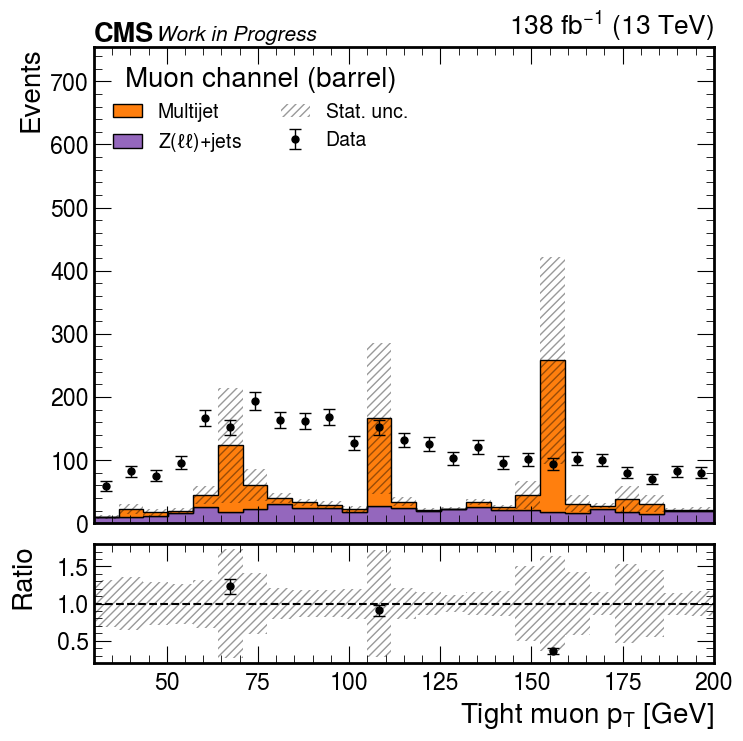

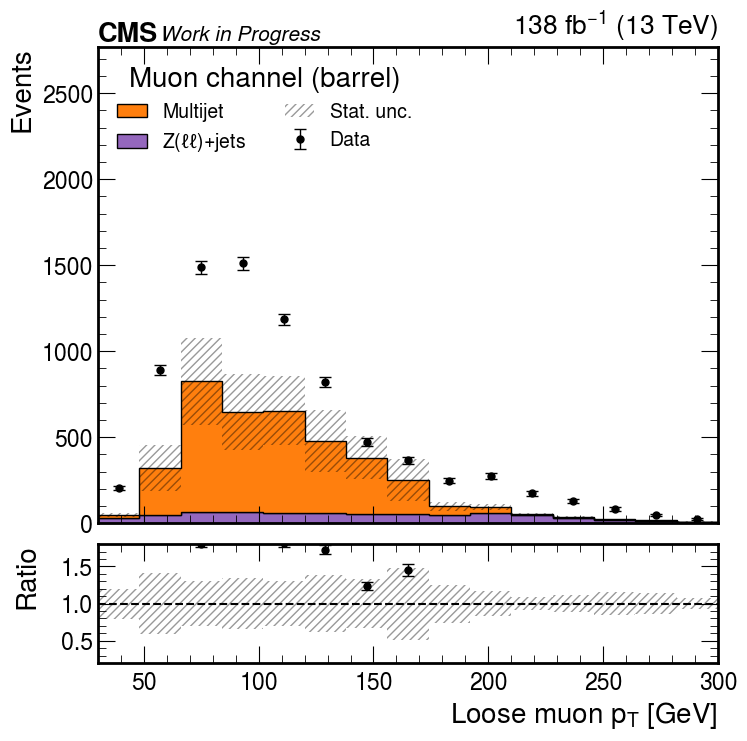

In [18]:
nice_ch = {
    "ele": "Electron channel",
    "mu": "Muon channel",
}

plt.rcParams.update({"font.size": 20})
add_data = True
add_soverb = False
    
from utils import plot_hists as plot_hists

if len(years)>1:
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/fakes/{ch}_Run2"
else:
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/fakes/{ch}_{year}"

PATH = f"/Users/fmokhtar/Desktop/AN_2024/ARC/fakes/"

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

if "barrel" in cut:
    add_text = " (barrel)"
elif "endcaps" in cut:
    add_text = " (endcaps)"
else:
    add_text = ""
    
plot_hists(hists, years, channels, vars_to_plot,
            add_data=True,
            logy=False,
            mult=1,
            outpath=PATH,
            text_=nice_ch[ch] + add_text,
            blind_region=False,
            save_as=cut,
            plot_Fake_unc=0.5,
#             plot_syst_unc=(SYST_UNC_up, SYST_UNC_down) if plot_syst_unc else None,
#            add_soverb=True,
           legend_ncol=2,
          )

In [19]:
PATH = f"/Users/fmokhtar/Desktop/AN_2024/ARC/fakes/"

lab_var_dict = {
    "FR_Nominal": "nominal",
    "FR_stat": "stat. unc.",
    "EWK_SF": "EWK SF stat. unc.",
}

def plot_matrix(FR, ch, variation, title=None):
    
    M = FR[variation]
    
    if ch == "ele":
        fig, ax = plt.subplots(figsize=(18,23))
    else:
        fig, ax = plt.subplots(figsize=(16,16))
    
    im = ax.imshow(M, vmax=1, vmin=0, cmap='coolwarm')
    
    # merge the first bin up 2000GeV
    ptbinning[ch][0] = 2000
    
    ax.set_xticks(ticks=np.arange(-0.5, (len(etabinning)-1), 1), labels=np.round(etabinning,2))
    ax.set_yticks(ticks=np.arange(-0.5, (len(ptbinning[ch])-1), 1), labels=np.round(ptbinning[ch],2))

    ax.tick_params(axis='x', which='major', pad=8)
    ax.tick_params(axis='y', which='major', pad=8)

    # Loop over data dimensions and create text annotations.
    for i in range(len(ptbinning[ch])-1):
        for j in range(len(etabinning)-1):
            if variation == "FR_Nominal":
                text = ax.text(j, i, str(np.round(M[i, j],3)), ha="center", va="center", fontsize=45)
            else: # annotate +=
                unc = abs(FR["FR_Nominal"][i, j] - M[i, j])
                text = ax.text(j, i, str(np.round(FR["FR_Nominal"][i, j],3)) + r" $\pm$ " + str(np.round(unc,3)), ha="center", fontsize=45)

    ax.set_xlabel(r"$\eta$", fontsize=30)
    ax.set_ylabel(r"$p_T$", fontsize=30)

    cbar = plt.colorbar(im, shrink=0.6)
    cbar.ax.tick_params(labelsize=30)
    
    # Improve axis ticks
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)

    hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=30)
    hep.cms.text("Work in Progress", ax=ax, fontsize=25);

    if "Nominal" in variation:
        title_ = r"fake rate"
    else:
        title_ = r"fake rate ($\pm$ " + f"{lab_var_dict[title]})"
    
    if ch == "ele":
        ax.set_title("Electron " + title_, pad=50, fontsize=50)
    else:
        ax.set_title("Muon " + title_, pad=50, fontsize=40)
    plt.tight_layout()        
    plt.savefig(f"{PATH}/fakerates/{ch}_fake_{title}.pdf")

# Fake rate extraction

In [20]:
years = [
    "2018",
    "2017",
    "2016",
    "2016APV",
]

channels = [
    "ele",
    "mu",
]

ptbinning = {}
ptbinning["ele"] = [2000, 200, 160, 120, 30]
ptbinning["mu"] = [180, 80, 60, 30]

etabinning = [0, 1.479, 2.5]

SIGMA = {}
for ch in channels:
    SIGMA[ch] = np.zeros((len(ptbinning[ch])-1,len(etabinning)-1))

variations = [
    "FR_Nominal", 
    "FR_stat_Up", 
    "FR_stat_Down", 
    "EWK_SF_Up", 
    "EWK_SF_Down",
]

FR = {}

for ch in channels:
    FR[ch] = {}        

    for variation in variations:

        FR[ch][variation] = np.zeros((len(ptbinning[ch])-1,len(etabinning)-1))
        print(variation, ch, FR[ch][variation].shape)
        
# get the SF
EWK_SF = {
    "ele":     {
        "Barrel_allpt":         {
            "Nominal": 0.796,
            "EWK_SF_Up": 0.813,
            "EWK_SF_Down": 0.780
        },
        "Endcap_allpt":         {
            "Nominal": 0.838,
            "EWK_SF_Up": 0.874,
            "EWK_SF_Down": 0.801
        },
    },
    "mu":     {
        "Barrel_allpt":         {
            "Nominal": 0.862,
            "EWK_SF_Up": 0.876,
            "EWK_SF_Down": 0.849
        },
        "Endcap_allpt":         {
            "Nominal": 0.847,
            "EWK_SF_Up": 0.870,
            "EWK_SF_Down": 0.823
        },
    },
}

for variation in variations:
    for ch in channels:

        print(f"variation {variation}, {ch} channel:")   

        for i in range(len(ptbinning[ch])-1):
            high_pt, low_pt = ptbinning[ch][i], ptbinning[ch][i+1]
            
            for j in range(len(etabinning)-1):
                low_eta, high_eta = etabinning[j], etabinning[j+1]
                
                if j == 0:
                    ewksf = EWK_SF[ch]["Barrel_allpt"]
                else:
                    ewksf = EWK_SF[ch]["Endcap_allpt"]
                
                ############### loop over years START
                num, den = 0, 0
                for year in years:

                    df = events_dict[year][ch]

                    loose, tight = {}, {}
                    for sample in ["Data", "WJetsLNu", "DYJets"]:
                        
                        pt = df[sample]["loose_lep1_pt"]
                        eta = abs(df[sample]["loose_lep1_eta"])
                        
                        msk_pt = (pt >= low_pt) & (pt < high_pt)
                        msk_eta = (eta >= low_eta) & (eta < high_eta)

                        # get data tight/loose ratio
                        msk_Nl1 = df[sample]["N_loose_lep"]==1                        
                        msk_Nt1 = df[sample]["N_tight_lep"]==1

                        loose[sample] = df[sample]["nominal"][msk_Nl1 & msk_pt & msk_eta].sum()                    
                        tight[sample] = df[sample]["nominal"][msk_Nt1 & msk_pt & msk_eta].sum()

                    if (variation=="FR_Nominal") or (variation=="FR_stat_Up") or (variation=="FR_stat_Down"):                
                        ewk_corr = ewksf["Nominal"]
                    else:
                        ewk_corr = ewksf[variation]

                    num += ( tight["Data"] - ewk_corr * (tight["WJetsLNu"] + tight["DYJets"]) )
                    den += ( loose["Data"] - ewk_corr * (loose["WJetsLNu"] + loose["DYJets"]) )

                ############### loop over years END
                
                SIGMA[ch][i,j] = (num/den) * np.sqrt( (np.sqrt(num)/num)**2 + (np.sqrt(den)/den)**2 )                    

                if (variation=="FR_stat_Up"):
                    FR[ch][variation][i,j] = (num/den) + SIGMA[ch][i,j]
                elif (variation=="FR_stat_Down"):
                    FR[ch][variation][i,j] = (num/den) - SIGMA[ch][i,j]
                else:
                    FR[ch][variation][i,j] = (num/den)

        print("----------------------------")        

FR_Nominal ele (4, 2)
FR_stat_Up ele (4, 2)
FR_stat_Down ele (4, 2)
EWK_SF_Up ele (4, 2)
EWK_SF_Down ele (4, 2)
FR_Nominal mu (3, 2)
FR_stat_Up mu (3, 2)
FR_stat_Down mu (3, 2)
EWK_SF_Up mu (3, 2)
EWK_SF_Down mu (3, 2)
variation FR_Nominal, ele channel:


KeyError: 'WJetsLNu'

In [10]:
for ch in channels:        
    for variation in [
        "FR_Nominal",
        "FR_stat_Up",        
        "EWK_SF_Up",
    ]:
        plot_matrix(FR[ch], ch, variation, title=variation.replace("_Up", ""))

# Get fake contribution from FR

In [11]:
import scipy
def get_finetuned_score(data, model_path):
    import onnx
    import onnxruntime as ort

    input_dict = {
        "highlevel": data.loc[:, "fj_ParT_hidNeuron000":"fj_ParT_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["AzureExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]

In [12]:
PR = {
    "ele":     {
        "Barrel_allpt": 0.793,
        "Endcap_allpt": 0.737
    },
    "mu":     {
        "Barrel_allpt": 0.948,
        "Endcap_allpt": 0.941
    },
}

ptbinning = {}
ptbinning["ele"] = [2000, 200, 160, 120, 30]
ptbinning["mu"] = [2000, 80, 60, 30]

for year in years:
    for ch in channels:
#         if ch != "mu":
#             continue        
        print(f"{year}, {ch} channel:")

#         outdir = f"/Users/fmokhtar/projects/boostedhiggs/eos/hww/Dec20_hww_{year}"
#         indir = f"/Users/fmokhtar/projects/boostedhiggs/eos/hww/Dec20_hww_uselooselep_{year}"
        
        outdir = f"/Users/fmokhtar/projects/boostedhiggs/eos/hww/Jun5_hww_{year}"
        indir = f"/Users/fmokhtar/projects/boostedhiggs/eos/hww/Jun5_hww_uselooselep_{year}"
                
        os.makedirs(f"{outdir}/Fake", exist_ok=True)

        if ch == "ele":
            if year == "2018":
                l = glob.glob(f"{indir}/EGamma*/outfiles/*_{ch}.parquet")
            else:
                l = glob.glob(f"{indir}/SingleElectron*/outfiles/*_{ch}.parquet")
        else:
            l = glob.glob(f"{indir}/SingleMuon*/outfiles/*_{ch}.parquet")
        
        for variation in variations:
#             if variation != "FR_Nominal":
#                 continue
            
            print(variation, "variation")
            data = pd.read_parquet(l)

            data["THWW"] = get_finetuned_score(data, "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx")

            if ch == "ele":
                Nt0 = (data["n_tight_electrons"]==0)
                Nt1 = (data["n_tight_electrons"]==1)
            else:
                Nt0 = (data["n_tight_muons"]==0)
                Nt1 = (data["n_tight_muons"]==1)

            data["nominal"] = 1            

            for i in range(len(ptbinning[ch])-1):
                high_pt = ptbinning[ch][i]
                low_pt = ptbinning[ch][i+1]

                msk_pt = (data["lep_pt"] >= low_pt) & (data["lep_pt"] < high_pt)

                for j in range(len(etabinning)-1):

                    if j == 0:
                        pr = PR[ch]["Barrel_allpt"]
                    else:
                        pr = PR[ch]["Endcap_allpt"]

                    low_eta = etabinning[j]
                    high_eta = etabinning[j+1]

                    msk_eta = (abs(data["lep_eta"]) >= low_eta) & (abs(data["lep_eta"]) < high_eta)

                    w_Nt0 = (pr * FR[ch][variation][i,j]) / (pr - FR[ch][variation][i,j])
                    w_Nt1 = (FR[ch][variation][i,j] * (pr-1)) / (pr - FR[ch][variation][i,j])
                    
                    data["nominal"][msk_pt & msk_eta & Nt0] = w_Nt0
                    data["nominal"][msk_pt & msk_eta & Nt1] = w_Nt1

                    data.to_parquet(f"{outdir}/Fake/fake_{year}_{ch}_{variation}.parquet")